In [1]:
from datasets import load_dataset
import pandas as pd

In [10]:
# Using glue qqp dataset
train_dataset = load_dataset("glue", "qqp", split="train")
test_dataset = load_dataset("glue", "qqp", split='test')
validation_dataset = load_dataset("glue", "qqp", split='validation')
train_df = train_dataset.to_pandas()
test_df = test_dataset.to_pandas()
valid_df = validation_dataset.to_pandas()

# Saving data
df.to_csv("quora_qqp_train.csv", index=False)
df.to_csv("quora_qqp_test.csv", index=False)
df.to_csv("quora_qqp_validation.csv", index=False)

In [11]:
small_train_ds = load_dataset("glue", "qqp", split="train").select(range(1000))
small_train_df = small_train_ds.to_pandas()

In [47]:
small_train_ds = small_train_ds.remove_columns("idx")
small_train_ds[0]

{'question1': 'How is the life of a math student? Could you describe your own experiences?',
 'question2': 'Which level of prepration is enough for the exam jlpt5?',
 'label': 0}

In [13]:
# Text Preprocessing
import re

def normalize_spaces(text: str) -> str:
    # strip ends + collapse multiple spaces
    return re.sub(r"\s+", " ", text.strip())

for df in (small_train_df, valid_df, test_df):
    # drop rows where q1 or q2 is missing
    df.dropna(subset=['question1', 'question2'], inplace=True)

    # normalize whitespace; keep punctuation/casing
    df['question1'] = df['question1'].astype(str).map(normalize_spaces)
    df['question2'] = df['question2'].astype(str).map(normalize_spaces)

    # drop rows that became empty after stripping
    df = df[(df['question1'] != "") & (df['question2'] != "")]

# save
small_train_df.to_csv("quora_qqp_small_train_clean.csv", index=False)
valid_df.to_csv("quora_qqp_valid_clean.csv", index=False)
test_df.to_csv("quora_qqp_test_clean.csv", index=False)

In [16]:
small_train_df = small_train_df.drop(columns=["idx"])
valid_df = valid_df.drop(columns=["idx"])
test_df = test_df.drop(columns=['idx'])

In [17]:
print(small_train_df.shape, valid_df.shape, test_df.shape)

(1000, 3) (40430, 3) (390965, 3)


In [18]:
# 2. load the model SBERT
from sentence_transformers import SentenceTransformer
import torch

model_name = "sentence-transformers/all-MiniLM-L6-v2"
model = SentenceTransformer(model_name)

# setup-device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
model = model.to(device)

In [21]:
# example to encode some sentences
sentences = [
    "What is artificial intelligence?",
    "Explain the concept of AI in simple terms.",
    "How to make pizza at home?"
]

embeddings = model.encode(sentences, convert_to_tensor=True)
print("Embedding shape:", embeddings.shape)
print("Example vector:", embeddings[0][:5])

Embedding shape: torch.Size([3, 384])
Example vector: tensor([-0.0158,  0.0149,  0.0091,  0.0313, -0.0217], device='cuda:0')


In [28]:
# 3. creating embedding vectors of the data
import numpy as np

def encode_texts(texts, batch_size=32):
    """
    - SBERT does mean pooling by default.
    - normalize the embedding=True makes vectors L2-normalized.
    - returns np.darray of shape (N, 384)
    """
    emb = model.encode(
        texts,
        batch_size=batch_size,
        normalize_embeddings=True,
        convert_to_tensor=True,
        show_progress_bar=True
    )

    return emb.cpu().numpy()

# ----- Train -------
E1_train = encode_texts(small_train_df['question1'].tolist())
E2_train = encode_texts(small_train_df['question2'].tolist())
y_train = small_train_df['label'].to_numpy(dtype=np.int64)

np.savez_compressed(
    "qqp_train_embeddings.npz",
    E1=E1_train, E2=E2_train, y=y_train
)

print("Saved: qqp_train_embeddings.npz")

# -------- Validation ---------
E1_valid = encode_texts(valid_df['question1'].tolist())
E2_valid = encode_texts(valid_df['question2'].tolist())
y_val = valid_df['label'].to_numpy()

np.savez_compressed(
    "qqp_valid_embeddings.npz",
    E1=E1_valid, E2=E2_valid, y=y_train
)

print("Saved: qqp_val_embeddings.npz")

# -------- Test (no labels) ----------
E1_test = encode_texts(test_df['question1'].tolist())
E2_test = encode_texts(test_df['question2'].tolist())

np.savez_compressed(
    "qqp_test_embeddings.npz"
)

print("Saved: qqp_test_embeddings.npz")

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Saved: qqp_train_embeddings.npz


Batches:   0%|          | 0/1264 [00:00<?, ?it/s]

Batches:   0%|          | 0/1264 [00:00<?, ?it/s]

Saved: qqp_val_embeddings.npz


Batches:   0%|          | 0/12218 [00:00<?, ?it/s]

Batches:   0%|          | 0/12218 [00:00<?, ?it/s]

Saved: qqp_test_embeddings.npz


### 🔍 Step 4 — What does .reshape(1, -1) mean?

- reshape changes the shape of an array.
- 1 → means 1 row (because we’re comparing one vector)
- -1 → means “automatically figure out how many columns” (i.e. embedding length)
- 
```yaml
Original shape: (384,)
After reshape:  (1, 384)
```

the result(cosine-similarity) looks like this:
```python
[[0.97]]
```

- That’s a 1×1 matrix (shape (1,1)).
- So we extract the value using:
```python
[0][0]
```

Now it’s just:
```python
0.97
```

In [33]:
# 4. compute cosine similarity
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

# compute cosine_similarity of val embeddings before pretraining
similarities = np.array([
    cosine_similarity(E1_valid[i].reshape(1,-1), E2_valid[i].reshape(1,-1))[0][0]
    for i in range(len(E1_valid))
])

# Attach to a dataframe for inspection
import pandas as pd
df_results = pd.DataFrame({
    "cosine_similarity": similarities,
    "label": y_val
})

print(df_results.head(10))

   cosine_similarity  label
0           0.740127      0
1           0.458366      0
2           0.877860      1
3           0.221908      0
4           0.954117      0
5           0.877590      1
6           0.599299      1
7           0.879703      1
8           0.979464      0
9           0.009661      0


In [39]:
from scipy.stats import pearsonr, spearmanr

# sims = np.sum(E1_valid*E2_valid, axis=1)
pearson, _ = pearsonr(similarities, y_val)
spearman, _ = spearmanr(similarities, y_val)
print("Pearson:", pearson, "Spearman:", spearman)

Pearson: 0.54986758993552 Spearman: 0.6193098892675138


## Note:- Shortcut to calculate cosine similarity in one go, without actually generating embedding by own

In [36]:
from sentence_transformers import SentenceTransformer
from sentence_transformers.evaluation import EmbeddingSimilarityEvaluator
import torch

model_name = "sentence-transformers/all-MiniLM-L6-v2"
model = SentenceTransformer(model_name)
model = model.to(device)

# Using STSB evaluator
evaluator = EmbeddingSimilarityEvaluator(
    sentences1 = valid_df['question1'],
    sentences2 = valid_df['question2'],
    scores = [score/5 for score in valid_df['label']],
    main_similarity="cosine",
)

evaluator(model)

{'pearson_cosine': 0.5498675890295038, 'spearman_cosine': 0.6193099090398987}

In [40]:
# 5. Fine-tune the model on our dataset.
from sentence_transformers import losses

# Define the loss function. In Softmax loss, we will also need to explicilty set the number of labels
train_loss = losses.SoftmaxLoss(
    model=model,
    sentence_embedding_dimension=model.get_sentence_embedding_dimension(),
    num_labels=2
)

In [54]:
from sentence_transformers.training_args import SentenceTransformerTrainingArguments
from sentence_transformers.trainer import SentenceTransformerTrainer

# increasing our training dataset
med_train_dataset = train_dataset.select(range(50000)).remove_columns("idx")

# Define Training arguments
args = SentenceTransformerTrainingArguments(
    output_dir = "base_embedding_model",
    num_train_epochs=1,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    warmup_steps=100,
    fp16=True,
    eval_steps=100,
    logging_steps=100
)

# Train the embedding model
trainer = SentenceTransformerTrainer(
    model=model,
    args=args,
    train_dataset=med_train_dataset, # it will throw error if we pass dataframe here.
    loss=train_loss,
    evaluator=evaluator
)

In [55]:
trainer.train()

2025/10/29 17:21:05 ERROR mlflow.utils.async_logging.async_logging_queue: Run Id 20954e9018d14349b174dce2a8744773: Failed to log run data: Exception: [Errno 2] No such file or directory: 'C:\\Users\\Deepam Shah\\Jupyter Notebook Python-20250329T150948Z-001\\Jupyter Notebook Python\\Artificial Intelligence\\Transformers\\LLM-Lab-Notebook\\Day-1-Semantic Similarity Engine\\mlruns\\0\\20954e9018d14349b174dce2a8744773\\params\\restore_callback_states_from_checkpoint'


Step,Training Loss
100,0.653900
200,0.604600
300,0.583400
400,0.556800
500,0.545500
600,0.536400
700,0.527500
800,0.525300
900,0.518100
1000,0.509800


TrainOutput(global_step=1563, training_loss=0.5353433873816629, metrics={'train_runtime': 1371.7838, 'train_samples_per_second': 36.449, 'train_steps_per_second': 1.139, 'total_flos': 0.0, 'train_loss': 0.5353433873816629, 'epoch': 1.0})

In [56]:
evaluator(model)

{'pearson_cosine': 0.45056921511992803, 'spearman_cosine': 0.5624523957687217}

# 😒😂😂😂😂

In [57]:
# Changing the loss function and training it for more epochs with high dataset size.
train_loss = losses.CosineSimilarityLoss(model=model)

huge_train_data = train_dataset.select(range(100000)).remove_columns("idx")
args = SentenceTransformerTrainingArguments(
    output_dir="base_embedding_model_huge",
    num_train_epochs=5,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    fp16=True,
    warmup_steps=100,
    logging_steps=100,
    eval_steps=100,
)

trainer = SentenceTransformerTrainer(
    model=model,
    args=args,
    loss=train_loss,
    train_dataset=huge_train_data,
    evaluator=evaluator
)

In [58]:
trainer.train()

2025/10/29 19:06:44 ERROR mlflow.utils.async_logging.async_logging_queue: Run Id 60df7155dd314d14b0a96a4d6aa666b8: Failed to log run data: Exception: [Errno 2] No such file or directory: 'C:\\Users\\Deepam Shah\\Jupyter Notebook Python-20250329T150948Z-001\\Jupyter Notebook Python\\Artificial Intelligence\\Transformers\\LLM-Lab-Notebook\\Day-1-Semantic Similarity Engine\\mlruns\\0\\60df7155dd314d14b0a96a4d6aa666b8\\params\\restore_callback_states_from_checkpoint'


Step,Training Loss
100,0.217000
200,0.146500
300,0.133000
400,0.133600
500,0.135200
600,0.136700
700,0.130800
800,0.128600
900,0.131600
1000,0.127400


TrainOutput(global_step=15625, training_loss=0.08699233345794678, metrics={'train_runtime': 5050.6578, 'train_samples_per_second': 98.997, 'train_steps_per_second': 3.094, 'total_flos': 0.0, 'train_loss': 0.08699233345794678, 'epoch': 5.0})

In [59]:
evaluator(model)

{'pearson_cosine': 0.734839425177581, 'spearman_cosine': 0.7129655421953915}

## It worked well now

In [60]:
model.save("finetuned_sbert_qqp_v1")

In [70]:
from sentence_transformers import SentenceTransformer, util

s1 = "How can I learn machine learning?"
s2 = "What are the best ways to study machine learning"
sim = util.cos_sim(model.encode(s1), model.encode(s2))
print(sim.item())

0.8719028234481812


In [ ]:
import faiss

# 6. FAQ Search(for better prompting)
faq_corpus = train_df['question2'].tolist()

# encode the corpus (all question2)
faq_embeddings = model.encode(
    faq_corpus,
    convert_to_numpy=True,
    normalize_embeddings=True,
    show_progress_bar=True
)

In [72]:
# Building FAISS index
dim = faq_embeddings.shape[1] # 384 for miniLM
index = faiss.IndexFlatIP(dim) 
index.add(faq_embeddings)

In [86]:
# Trial
query = "How can i improve my Python coding skills?"
query_emb = model.encode([query], normalize_embeddings=True)

k=4 # top results
scores, indices = index.search(query_emb, k)

# drop the first result (the query itself)
scores, indices = scores[:, 1:], indices[:, 1:]

# show results
print("\n Query:", query)
for i, idx in enumerate(indices[0]):
    print(f"{i+1}.{faq_corpus[idx]} (score: {scores[0][i]:.3f})")


 Query: How can i improve my Python coding skills?
1.How do I learn Python Programming the most effective way? (score: 0.922)
2.How can I become a really really good Python programmer? (score: 0.907)
3.How do I start learning python web programming from scratch to advanced? (score: 0.896)


In [121]:
import re
import numpy as np
import faiss

d = E2_valid.shape[1]  # embedding dimension

# Creating FAISS index 
faiss_index = faiss.IndexFlatIP(d)

faiss_index.add(E2_valid.astype("float32"))

In [122]:
def get_top_similarity_result(query: str, k=4):
    # clean up query text
    q = re.sub(r"\s+", " ", query.strip())

    # encode query using same model
    query_emb = model.encode([q], normalize_embeddings=True)
    query_emb = np.asarray(query_emb, dtype="float32")  # FAISS expects float32

    # search top-k similar results
    scores, indices = faiss_index.search(query_emb, k)

    scores, indices = scores[:, 1:], indices[:, 1:]

    # show results
    print("\nQuery:", q)
    for i, idx in enumerate(indices[0]):
        print(f"{i+1}. {faq_corpus[idx]} (score: {scores[0][i]:.3f})")

In [123]:
query = "How can i improve my Python coding skills?"
get_top_similarity_result(query)


Query: How can i improve my Python coding skills?
1. Is there anything like a white hole and its theory? (score: 0.471)
2. How do you determine the formula for tangential acceleration? (score: 0.471)
3. What is the best platform/media/source to learn digital marketing? (score: 0.463)


## making a UMAP plot here

In [88]:
# 7. UMAP plot on validation embeddings

pair_embed = 0.5* (E1_valid + E2_valid)
labels = y_val.astype(int)

from umap import UMAP

# We reduce the input diensions from 384 to 5 
umap_model = UMAP(
    n_components=5, min_dist=0.0, metric="cosine", random_state=42
)
reduced_embeddings = umap_model.fit_transform(pair_embed)

C:\Users\Deepam Shah\AppData\Local\Programs\Python\Python312\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


In [90]:
from hdbscan import HDBSCAN

# We fit the model and extract the clusters
hdbscan_model = HDBSCAN(
    min_cluster_size=50, metric='euclidean', cluster_selection_method="eom"
).fit(reduced_embeddings)

clusters = hdbscan_model.labels_

# how many cluster did we generate?
len(set(clusters))

C:\Users\Deepam Shah\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\Deepam Shah\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


154

In [97]:
import numpy as np
import pandas as pd

# disable text truncation
pd.set_option('display.max_colwidth', None)

# print first three documents in cluster 0
cluster = 0
for index in np.where(clusters == cluster)[0][:3]:
    print(valid_df.iloc[index], "\n")

question1    What is your new year resolution, short term and long term goal for 2017?
question2                            What will be your New Year's resolution for 2017?
label                                                                                1
Name: 93, dtype: object 

question1    What would be your New Year resolutions for 2017?
question2        What are your New Years resolutions for 2017?
label                                                        1
Name: 521, dtype: object 

question1    What is your new year resolution for 2017 or goal for 2017?
question2                       What are your new year resolutions’2017?
label                                                                  1
Name: 569, dtype: object 



In [98]:
# Visualize the plot
import pandas as pd

# We reduce the input diensions from 384 to 2
reduced_embeddings = UMAP(
    n_components=2, min_dist=0.0, metric="cosine", random_state=42
).fit_transform(pair_embed)

C:\Users\Deepam Shah\AppData\Local\Programs\Python\Python312\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


In [100]:
# Create dataFrame
df = pd.DataFrame(reduced_embeddings, columns=['x', 'y'])
df['title'] = valid_df['question1']
df['cluster'] = [str(c) for c in clusters]

# Select outliers and non-outliers (clusters)
to_plot = df.loc[df.cluster != '-1', :]
outliers = df.loc[df.cluster == "-1", :]

In [102]:
# from your earlier variables
clusters_df = to_plot.copy()   # all points with cluster != -1
outliers_df = outliers.copy()  # all points with cluster == -1

(np.float64(-12.664507102966308),
 np.float64(13.170059394836425),
 np.float64(-12.071831321716308),
 np.float64(11.186108207702636))

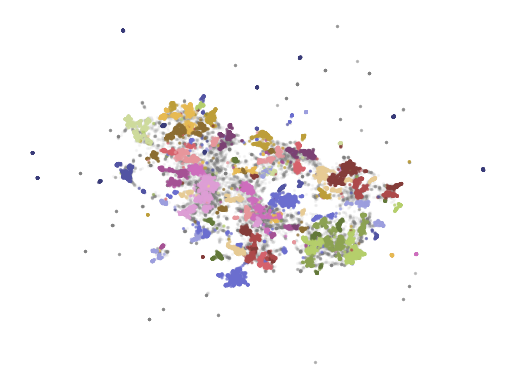

In [103]:
import matplotlib.pyplot as plt

# Plot outliers and non-outliers respectively
plt.scatter(outliers_df.x, outliers_df.y, alpha=0.05, s=2, c="grey")
plt.scatter(
    clusters_df.x, clusters_df.y, c=clusters_df.cluster.astype(int),
    alpha=0.6, s=2, cmap="tab20b"
)
plt.axis("off")

- This is visually appealing and does not allow us to see what is happening inside the cluster, we could also do topic modeling use BERTopic model

In [105]:
from bertopic import BERTopic

# Train our model with our previously defined models
topic_model = BERTopic(
    embedding_model=model,
    umap_model=umap_model,
    hdbscan_model=hdbscan_model,
    verbose=True
).fit(valid_df['question1'], E1_valid)

2025-10-30 14:35:35,499 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-10-30 14:37:01,244 - BERTopic - Dimensionality - Completed ✓
2025-10-30 14:37:01,250 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-10-30 14:37:05,908 - BERTopic - Cluster - Completed ✓
2025-10-30 14:37:05,956 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-10-30 14:37:06,805 - BERTopic - Representation - Completed ✓


In [106]:
topic_model.get_topic_info()

,Topic,Count,Name,Representation,Representative_Docs
0,-1,18569,-1_the_what_is_of,"[the, what, is, of, in, and, are, to, how, do]","[Where do I have to learn digital marketing course for for free?, How do you get a job at Google?, Why do we need laws in society? What would life be like without them?]"
1,0,2071,0_engineering_exam_for_prepare,"[engineering, exam, for, prepare, university, mba, college, mechanical, in, science]","[What are the best engineering colleges in India?, Which are the best books to prepare for IAS exam?, What rank and marks are required on the GATE Exam to get a job in PSU for mechanical engineering?]"
2,1,1792,1_movie_movies_who_bollywood,"[movie, movies, who, bollywood, modi, did, was, tv, watch, his]","[What is your favorite Bollywood movie in 2016?, Which are best Bollywood movies?, What do you think about when you watch a movie?]"
3,2,853,2_trump_donald_clinton_hillary,"[trump, donald, clinton, hillary, president, vote, election, presidential, obama, will]","[Who is better Donald Trump or Hillary Clinton and why?, Who will win Hillary Clinton Or Donald Trump?, Who would be a better president: Hillary Clinton or Donald Trump?]"
4,3,664,3_quora_questions_question_ask,"[quora, questions, question, ask, answer, answers, on, google, why, people]","[Why can't I ask any questions on Quora?, How so I ask questions on Quora?, How so I ask questions on Quora?]"
...,...,...,...,...,...
126,125,53,125_pollution_biotic_abiotic_forest,"[pollution, biotic, abiotic, forest, air, factors, trees, biodiversity, forests, environmental]","[What are the main causes of air water and land pollution?, What are some examples of water pollution?, What is the meaning of air pollution?]"
127,126,53,126_protein_whey_supplement_vitamin,"[protein, whey, supplement, vitamin, banana, diarrhea, bananas, workout, eat, reviews]","[What if I take whey protein and don't workout?, Which is the best whey protein in the market?, What is whey protein?]"
128,127,51,127_cheating_partner_wife_cheated,"[cheating, partner, wife, cheated, husband, know, my, me, affair, cheater]","[How will you know if your partner was or still cheating on you?, How do you know when your partner is cheating?, How do you know when your partner is cheating?]"
129,128,50,128_countries_africa_country_poorest,"[countries, africa, country, poorest, france, mexico, guinea, economic, america, states]","[How do France's economic activities compare and contrast to those of Mexico?, What is the poorest country in Asia, and how does its educational system compare to the poorest country in Africa?, What is the poorest country in Asia, and how does its health system compare to the poorest country in Africa?]"


In [108]:
topic_model.get_topic(0)

[('engineering', np.float64(0.02628727096386999)),
 ('exam', np.float64(0.019584456631392997)),
 ('for', np.float64(0.01634507926157909)),
 ('prepare', np.float64(0.016154940315202943)),
 ('university', np.float64(0.015302367635268826)),
 ('mba', np.float64(0.013937116388687963)),
 ('college', np.float64(0.013389139897843893)),
 ('mechanical', np.float64(0.012992286246469267)),
 ('in', np.float64(0.012099517438198329)),
 ('science', np.float64(0.011916775692937457))]